# Mapping Literary Chiaroscuro in Joseph Conrad's *Heart of Darkness*
## Ken Miura

16 December 2020

Introduction to Computational Literary Analysis

Department of English and Comparative Literature, Columbia University

Instructor: Jonathan Reeve

## Abstract

A word frequency analysis of the lemmas related to 'darkness' and 'light' is used to determine the function of literary chiaroscuro as a device in Joseph Conrad's *Heart of Darkness*. It is shown that light and darkness are frequently juxtaposed in a manner which positions darkness dominating the light, and that this chiaroscuro is employed by Conrad to create narrative structure for his themes. Furthermore, the article argues that the frequency distribution data and its visualizations enable descriptive, quantifiable assessments of past critiques and analyses of the text. 

## Introduction

As the eponymous motif in *Heart of Darkness*, the role of darkness in Conrad's definitive work has been the subject of intensive research by both quantitative and qualitative methods. In this article, my aim is to analyze Conrad’s use of darkness in juxtaposition to light within the text to create contrast, which we will define as literary chiaroscuro. By examining the function of this contrast in *Heart of Darkness*I seek to assess the validity of post-colonial criticisms surrounding the text from a descriptivist perspective. 

Chiaroscuro, a term originally applied to paintings to describe sharp tonal contrasts, may be used in the context of literary texts to denote the contrast provided by the juxtaposition of opposing lexical elements. The French usage of the term, 'clair-obscur', has been used in reference to both literature and philosophy as an analogy to the pictoral technique, to clarify ('clair') and obscure ('obscur') elements through linguistic arrangement. In his critique of Condillac's usage of 'clair-obscur' as a literary device, Manon Plante argues that chiaroscuro gains additional depth in meaning when applied to textual contexts: 


>By using the compound term in a text on *clarté* in grammar, Condillac retains their traditional meanings in the field of letters, rather than painting. Indeed, these two components bring their connoted meanings into the compound term to signal implicitly Condillac’s vision of *clarté* in grammar: *clarté* in ideas and *obscurité* of passions are fused, having neither positive nor negative value... (482)


In other words, the concept of chiaroscuro when applied to the context of literature transcends that of the pictoral confines of tonal contrast. Beyond the literal dichotomy of light and dark, chiaroscuro becomes a device which implicitly connotes the ambiguous spectrum of clarity embedded within the traditional literary usage of those terms. Given that lexical arrangement can be used to identify literary chiaroscuro, it follows that quantitative techniques can then be applied to investigate its usage and function.  

Word frequency and distribution data has previously been used as the basis for linguistic analysis to elucidate the function of darkness within *Heart of Darkness*. Michael Stubbs conducted an extensive corpus analysis of the text to establish the validity of such methods, arguing that they "provide a more detailed descriptive basis" for literary interpretations of the book (5). Building upon Stubbs' framework, Monica Turci employed linguistic analysis of word frequencies and collocation patterns to assign meaning to the lemma 'dark' and its function within the text in relation to imperialist themes. She finds that the lemma 'dark' is used predominantly to "connote negatively the main character Kurtz (110)." Perhaps most interestingly, despite the volumes of literature produced on the representation of Africa as a 'dark continent' in Conrad's novel, Turci asserts the contrary - that mentions of Africa in relation to the lemma 'dark' is starkly absent: 


> [...] while the word list search reveals a consistent reiteration of the lemma dark*, it also reveals an almost complete absence of references to Africa, which is mentioned only once in the whole novella. (104)


Turci's findings, along with Plante's interpretation of the function of chiaroscuro in literary contexts, provides a framework through which we may examine the ways in which Conrad utilizes this technique in regards to imperialism. What I hope to contribute through this analysis of chiaroscuro in Conrad's *Heart of Darkness* is to elucidate the ways in which the tension between light and dark is created and exploited to highlight certain elements and themes while obscuring or otherwise diminishing others. 

In [1]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords as stops 

import spacy 
import scattertext as st
from pprint import pprint
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 

import pandas as pd
from collections import Counter

import requests
import json

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.colors as clrs

## Building the corpus

Natural languange processing is used in this analysis to quantify and visualize the frequency distribution patterns of dark and light lemmas within *Heart of Darkness*.  The full electronic transcription of the text from the corpus-DB database is used, which is an edited copy of the version available on Project Gutenberg. The full script of *Apocalypse Now Redux*, the extended edit of the film by Francis Coppola, is also used for the purposes of comparative analysis. The natural language processing package spaCy is used to digitally annotate these texts for analysis and implement most of these computational methods.

In [2]:
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe(WordnetAnnotator(nlp.lang), after='tagger')

In [3]:
url = "http://corpus-db.org/api/author/Conrad, Joseph"

In [4]:
response = requests.get(url = url)
conrad = json.loads(response.text)

# remove second occurence of Heart of Darkness
conrad.pop(7)

# create list of titles and corresponding CorpusDB ids
conradTitles = [book['title'] for book in conrad[:-3]]
conradIds = [book['id'] for book in conrad[:-3]]

In [5]:
#function to get text from CorpusDB. Sourced from lecture 14

def getFullText(bookId): 
    url = f'http://corpus-db.org/api/id/{bookId}/fulltext'
    response = requests.get(url)
    if response.ok: 
        bookText = json.loads(response.text)
        if len(bookText) > 0: 
            return bookText[0]['text']
        else:
            return 'empty' 
    else:
        print('ERROR: response not ok! Abandon ship!')

In [6]:
conradTexts = [getFullText(bookId) for bookId in conradIds]

In [7]:
# remove empty texts from list of texts and titles
for i, text in enumerate(conradTexts):
    if text == 'empty':
        title = conradTitles[i]
        conradTitles.remove(title)

conradTexts.remove('empty')
conradTexts.remove('empty')

In [8]:
heart = conradTexts[0]
heartDoc = nlp(heart)

In [9]:
apocNow = open('apocalypseNow.md', encoding='utf-8').read()
apocNowDoc = nlp(apocNow)

## Identifying light and darkness

In order to run frequency distribution analysis on the text, the sets of 'dark' and 'light' words must first be defined. WordNet, a lexical database which groups words into "sets of cognitive synonyms (synsets)" is used to construct these sets (Princeton University). By extracting the lemmas grouped within the synsets 'dark' and 'light', we are able to compile a list of words which are meaningfully related to these two terms. Given the wide range of meanings embedded in the lemma 'light', those synonymous lemmas unrelated to the context used in analysis were manually removed. 

In [10]:
def getHyponym(word): 
    return word.hyponyms()

def isSynset(node): 
    return type(node) == nltk.corpus.reader.wordnet.Synset

def getLemmas(tree): 
    allLemmas = []
    for node in tree: 
        if isSynset(node): 
            nodeLemmas = node.lemma_names()
            for lem in nodeLemmas: 
                allLemmas.append(lem)
        else: 
            nodeLemmas = getLemmas(node)
            for lem in nodeLemmas: 
                allLemmas.append(lem)
    return allLemmas

def makeLemmaList(synsets):
    allLems = []
    for synset in synsets:
        tree = synset.tree(rel = getHyponym)
        lemmaList = [lem.lower().replace('_', ' ') for lem in getLemmas(tree)]
        for lem in lemmaList:
            allLems.append(lem)
    return allLems

In [11]:
light = wn.synsets('light')
dark = wn.synsets('dark')

In [12]:
lightLems = [lem for lem in set(makeLemmaList(light)) if not ' ' in lem]
darkLems = [lem for lem in set(makeLemmaList(dark)) if not ' ' in lem]

In [13]:
removeFromLight = ['swooning',
                    'short',
                    'wakeful',
                    'low-cal', 
                    'unhorse', 
                    'abstemious', 
                    'streamer', 
                    'shaft', 
                    'sluttish', 
                    'dismount', 
                    'perch', 
                    'weak', 
                    'light-headed', 
                    'tripping', 
                    'wanton', 
                    'calorie-free', 
                    'lightheaded', 
                    'lite', 
                    'loose', 
                    'go-ahead', 
                    'promiscuous', 
                    'scant', 
                    'easy', 
                    'idle',
                    'fall',
                    'flood',
                    'faint']

for word in removeFromLight:
    lightLems.remove(word)

## Plotting Chiaroscuro in Narrative Time

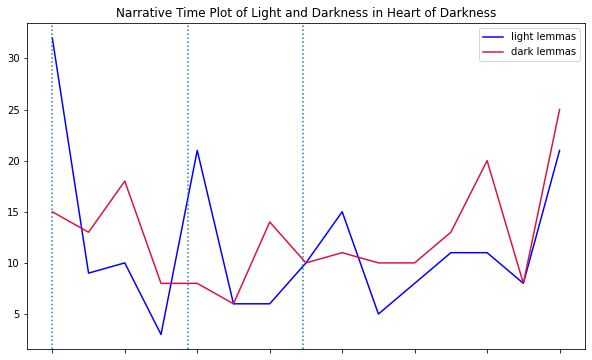

In [14]:
# returns whether the token is the weightless meaning of light
def isLightWeight(token):
    if token.lemma_ == 'light' and token.pos_ == 'ADJ':
        return True
    
# puts occurences of given word in appropriate bins
def binIt(doc, lemmas):
    segments, bins = pd.cut(range(len(doc)), bins = 15, retbins = True)
    locs = [token.i for token in doc if token.lemma_ in lemmas and not isLightWeight(token)]
    binned = pd.cut(locs, bins).value_counts()
    return binned

heartBinnedDF = pd.DataFrame({"light lemmas": binIt(heartDoc, lightLems), 
                              "dark lemmas": binIt(heartDoc, darkLems)})

cmap = clrs.ListedColormap(['blue', 'crimson'])
heartAx = heartBinnedDF.plot(figsize = (10, 6), colormap = cmap, 
                                 title = 'Narrative Time Plot of Light and Darkness in Heart of Darkness')

for marker in ["\nI\n", "\nII\n", "\nIII\n"]:
    markerIndex = heart.index(marker)
    heartAx.axvline((markerIndex / len(heart) * 10), linestyle = ":")

Unsurprisingly, a cursory analysis of the narrative time plot falls in line with popular understanding of the text. The influence of darkness grows over the course of the narrative, eventually overwhelming light. The frequency of light lemmas is highest at the beginning of the text, while darkness peaks at the end, confirming widely shared interpretations of the text's narrative structure. Looking beyond discrete frequency values however, more descriptive trends emerge. The vertical lines on the narrative time plot each mark the beginning of the three parts which constitute the narrative. With this in mind, one can immediately recognize the pattern in the distribution of light and dark lemmas throughout the course of the text. Each part begins with a spike in light lemmas, followed by a subsequent drop accompanied by a spike in the frequency of dark lemmas. The three parts mirror each other in regards to this pattern of ebb-and-flow, with light and dark oscillating against each other in a bid for dominance. Although light maintains a stronger presence in the first two parts of the narrative, this trend is ultimately broken in the climax of final third, when darkness emerges as the dominant force. 

Narrative factors obviously influence this trend to a large degree. The first two parts of the story occur before Marlow's meeting with Kurtz, the main figure with whom the lemma 'dark' is predominatly associated (Turci 110). Furthermore, this conflicting dynamic between the wavering light and underlying darkness plays to narrative tropes commonly found in literature. For example, a spike in light lemmas occurs at the beginning of the second chapter, when Marlow is on the steamboat with his fellow 'pilgrims' immediately before they are attacked. The darkness can clearly be seen to be lurking below the light, precipitating the attack and the subsequent spike in dark lemmas. 

However, a closer qualitative analysis of these spikes in both dark and light lemmas reveal a more nuanced understanding of these oscillating patterns in line with Condillac's definition of 'clair-obsur'. 

In [15]:
def findChiaroscuro(doc):
    csList = []
    for token in doc:
        if token.lemma_ in lightLems and not isLightWeight(token):
            nbors = [token.nbor(i) for i in range(-20, 20)]
            for nbor in nbors:
                if nbor.lemma_ in darkLems:
                    csList.append((token, nbor))
    return csList

def printChiaroscuro(doc):
    csSents = []
    for token, nbor in findChiaroscuro(doc):
        if token.sent == nbor.sent:
            sents = f'{token}, {nbor}:\n {token.sent.text} \n'
            csSents.append(sents)
        elif token.i < nbor.i:
            sents = f'{token}, {nbor}:\n {token.sent.text} {nbor.sent.text}\n'
        else: 
            sents = f'{token}, {nbor}:\n {nbor.sent.text} {token.sent.text}\n'
        
    return csSents

segments, bins = pd.cut(range(len(heartDoc)), bins = 15, retbins = True)


print('Light\n\nPeak 1\n\n' + printChiaroscuro(heartDoc[0:(int(bins[1]))])[2])
print('Peak 2\n\n' + printChiaroscuro(heartDoc[(int(bins[4])):(int(bins[5]))])[1])
print('Peak 3\n\n' + printChiaroscuro(heartDoc[(int(bins[8])):(int(bins[9]))])[-1])

Light

Peak 1

glare, gloom:
 And farther west on the
upper reaches the place of the monstrous town was still marked ominously
on the sky, a brooding gloom in sunshine, a lurid glare under the stars.

 

Peak 2

torchlight, sinister:
 The movement
of the woman was stately, and the effect of the torchlight on the face
was sinister.

 

Peak 3

light, darkness:
 The point was in his
being a gifted creature, and that of all his gifts the one that stood
out preeminently, that carried with it a sense of real presence, was his
ability to talk, his words—the gift of expression, the bewildering,
the illuminating, the most exalted and the most contemptible, the
pulsating stream of light, or the deceitful flow from the heart of an
impenetrable darkness.

 



By searching for collocations of light and dark lemmas in close proximity within these peaks on the narrative time plot, Conrad's implementation of chiaroscuro can be qualitatively analyzed. The three samples above are instances in which light and dark lemmas occur in the same sentence, and are located in the first, second, and third peaks of light lemmas occuring at the beginning of each chapter. The two lemmas (i.e. glare, gloom) denote the light and dark lemmas present in the sentence. 

The first sentence is located at the beginning of the narrative. Here, light is introduced not as the antithesis of darkness, but rather its enabling agent. Negative sentiment is peppered throughout the description, with words such as "monstrous" and "ominously" strongly foreshadowing the events to come. The light lemma in this sentence, "glare", is also a word with relatively negative connotations which is further magnified by the adjacent adjective, "lurid". The sentence from the second peak echoes this pattern, revealing a dynamic between the two motifs previously unseen at the macroscopic narrative level. 

It is apparent from examining these sentences that light and darkness do not operate as opposing forces in this narrative. To the contrary, light exists in *Heart of Darkness* to make clear the darkness lying in obscurity, to serve darkness as its conduit and its mirror. This interpretation of chiaroscuro manifests itself most clearly in the peak of light occuring at the start of the third chapter, when Marlow finally comes into contact with Kurtz. The sentence is full of light, radiating with positively aligned descriptors such as "gifted", "preeminently", and "exalted". However, the narrative's titular motif reveals itself to be the source of all light - "the heart of an impenetrable darkness". 

In [16]:
print('Dark\n\nPart 3\n')
print(printChiaroscuro(heartDoc[(int(bins[12])):(int(bins[13]))])[1])

Dark

Part 3

clear, dark:
 The night was very
clear; a dark blue space, sparkling with dew and starlight, in which
black things stood very still. 



In this narrative, light cannot exist without darkness. The dominance of darkness is made abundantly clear when examining collocations of light and dark lemmas in peaks of darkness. Sentences in which light and dark lemmas occur concordantly are notably absent in these segments of the narrative, in contrast to what was found in peaks of light. The absence of such instances serve to reinforce the inequal dynamic of power between these two forces, firmly positioning light as subservient to darkness. 

The sentence above is one of the only collocations of light and dark lemmas found in the peaks of darkness, occuring near the end of part three. At this point in narrative time, the light has completely given way to darkness, symbolized here by the "night". Light is represented by the flickering illumination of "starlight", whose sole purpose is to direct attention to the "black things". 

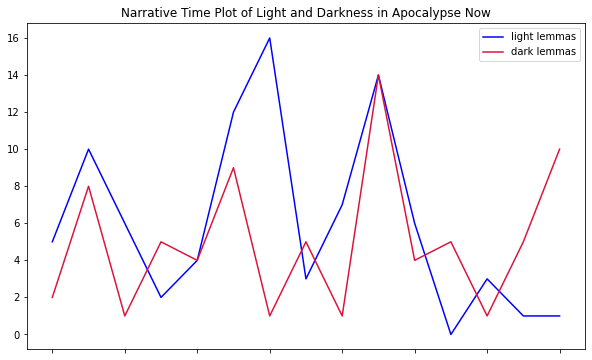

In [17]:
apocNowBinnedDF = pd.DataFrame({"light lemmas": binIt(apocNowDoc, lightLems), 
                                "dark lemmas": binIt(apocNowDoc, darkLems)})

apocAx = apocNowBinnedDF.plot(figsize = (10, 6), colormap = cmap, 
                              title = 'Narrative Time Plot of Light and Darkness in Apocalypse Now')

The narrative time plot above utilizes the same computational methods as the previous figure but applied to the script of *Apocalypse Now*. The general structure of the three peaks in lemma frequency has been preserved in the adaptation, but the spikes in darkness have been shifted to occur concurrently with the spikes in light. This may have to do with the visual nature of the medium, limiting the dialogue to be explicit in its expression of thematic elements. A further visual analysis of tonal contrast in the film may yield interesting results, but is beyond the scope of this article. It can also be seen that the film adaptation is more explicit in its portrayal of the triumph of darkness in the conclusion compared to the original text. 

This comparison between the literary and visual mediums offer a look into the validity of Plante's argument. While the ambiguous tension created by chiaroscuro in the novella allowed for a richer interpretation utilizing the literary connotations of light and darkness, the dynamic in the film adaptation is made explicit, leaving little room for obfuscation. In the visual medium, the tension is presented as a stuggle between light and dark in which darkness is ultimately triumphant.

## Scattertext

Scattertext is a visualization tool developed by Jason Kessler which takes distinguishing terms in corpora to create interactive HTML scatter plots. Using this tool, we may quantitatively analyze the frequencies at which words and phrases occur in proximity to the sets of light and dark lemmas constructed above. For this analysis, proximity was defined as a word occuring in the same sentence as the light and/or dark lemma. 

In [18]:
cols = ("token", "lemma", "text")
rows = []

for token in heartDoc[20:]: 
    if token.lemma_ in lightLems and not isLightWeight(token):
        sent = token.sent.text
        row = [token.text, "light", sent]
        rows.append(row)
    elif token.lemma_ in darkLems:
        sent = token.sent.text
        row = [token.text, "dark", sent]
        rows.append(row)

chiaroscuroDF = pd.DataFrame(rows, columns = cols)

In [19]:
corpus = st.CorpusFromPandas(chiaroscuroDF,
                            category_col = 'lemma',
                            text_col = 'text',
                            nlp = nlp).build()

In [20]:
termFreqDF = corpus.get_term_freq_df()
termFreqDF['luminance'] = corpus.get_scaled_f_scores('light')
pprint(list(termFreqDF.sort_values(by = 'luminance', ascending = False).index[:10]))

['light',
 'sun',
 'clear',
 'the sun',
 'like a',
 'without',
 'him',
 'her',
 'was not',
 'sunshine']


In [21]:
termFreqDF = corpus.get_term_freq_df()
termFreqDF['darkness'] = corpus.get_scaled_f_scores('dark')
pprint(list(termFreqDF.sort_values(by = 'darkness', ascending = False).index[:10]))

['shadow',
 'black',
 'some',
 'lived',
 'night',
 'blue',
 'darkness',
 'the night',
 'dark',
 'they']


In [22]:
html = st.produce_scattertext_explorer(corpus,
          category = 'light',
          category_name= 'Light',
          not_category_name='Dark',
          width_in_pixels=1000,
          minimum_term_frequency=2,
          metadata=chiaroscuroDF['token'])
open("Chiaroscuro-Visualization.html", 'wb').write(html.encode('utf-8'))

721246

The html file produced can be viewed here:

https://rawgit.com/kmiumiu/computational-literary-analysis/main/Chiaroscuro-Visualization.html

An examination of this scatter plot yields several points of interest for further analysis. As expected, the words most frequently collocated with both dark and light lemmas are stop words such as "the" and "and". The lemmas themselves, such as "light" and "dark", also occur with some frequency in collocation with the opposite lemma. More importantly, by looking at the content words, we are able to identify the objects of Conrad's focus in the narrative through the use of chiaroscuro. 

In line with Turci's findings in her analysis of the lemma 'dark', there is a notable absence of the African setting in collocation with both light and dark lemmas in *Heart of Darkness*. "They" and "their" are some of the top collocations with the lemma dark, suggesting a negative connotation of the ambiguous other. In fact, despite the substantial depth of vocabulary documented in the visualization, it would be difficult to discern the setting at all from an analysis of this figure alone.  Even the "characteristic" words of the text, which occur with higher frequency in *Heart of Darkness* relative to its average wider usage, do little to demystefy the narrative context of the story. This suggests a deliberate effort on Conrad's part to diminish the significance of the setting in relation to the central themes of the text through obfuscation.

## Conclusion 

Chiaroscuro demonstrably has the effect of highlighting certain features while obscuring others. As noted by Plante, this is especially the case in literary usages of the technique, whereby chiaroscuro is used not only to contrast, but to absorb and fuse subservient elements into the dominant element to deprive them of value and meaning. That which is highlighted by chiaroscuro is made clearer and stronger. By the same token, all other elements are relegated to the shadow of obscurity, gaining meaning only in relation to the highlighted object. In the case of Conrad's *Heart of Darkness*, that object is the European male represented by the character Kurtz. The setting of Africa and themes of imperialism are rendered irrelevant outside of the context of the European male, echoing post-colonial criticisms of the text by scholars such as Edward Said who argued that Conrad recognized the issue of imperialism while simultaneously disregarding it as insignificant (31). 

## Works Cited

Kessler, Jason. "Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ". *ACL System Demonstrations*. 2017. Link to preprint: arxiv.org/abs/1703.00565

Miller, D. R., and Monica Turci. *Language and Verbal Art Revisited : Linguistic Approaches to the Study of Literature*. Equinox Publishing Ltd, 2007. EBSCOhost, search.ebscohost.com/login.aspx?direct=true&db=e025xna&AN=547838&site=ehost-live&scope=site.

Plante, Manon. "The Art of Chiaroscuro Writing: Condillac and the Question of Word Order." *Journal for Eighteenth-Century Studies*, vol. 37, no. 4, 2014, pp. 473-485, doi:10.1111/1754-0208.12201.

Princeton University "About WordNet." *WordNet*. Princeton University. 2010. 

Said, Edward W. *Culture and Imperialism*. New York: Knopf, 1994. Print.

Stubbs, Michael. “Conrad in the Computer: Examples of Quantitative Stylistic Methods.” *Language and Literature*, vol. 14, no. 1, Feb. 2005, pp. 5–24, doi:10.1177/0963947005048873.